# Introduction

Quantum computing is a rapidly developing field which promises to aid it users with faster computations and the ability to solve currently intractable problems in mere minutes. However, a relatively unexplored avenue for QC is in Machine Learning. Machine learning is the "training" of models for a variety of purposes, such as image analysis, voice recognition, clustering, but very interestingly, it is able to notice patterns within data sets of numbers and using those patterns it can predict what might be the next set of numbers in that data set. This is called regression. In this project, I will be using a Quantum Long Short Term Memory circuit on a CSV containing the historical prices of amazon products to predict their future marketplace value.

This project will contain 2 main sections: 
   1. The data section
   2. The QLSTM section
    
A key part of using QLSTM to predict item prices is gathering good data which then needs to be processed before being passed into the circuit. To collect our data, we will be using the Keepa API, a very useful tool that can allow you to access the price histories of amazon products. We start off with importing our packaages.

In [1]:
import pandas as pd
import time
import numpy as np
import math                                            
import matplotlib.pyplot as plt                                                                           
import torch                                     # Getting all the packages and stuff required for this to work,
from torch.utils.data import DataLoader          # we use these to get the historical data, edit it, create out
from torch import nn                             # quantum circuit, etc
from torch.utils.data import Dataset
from utils import *
import pennylane as qml

import keepa
accesskey = 'e4b1cv16b893ok3ms868idcbd120b8b9q5jdrsnrh0tcv6uo4pc8sti7dladam3v'
api = keepa.Keepa(accesskey)

INFO:keepa.interface:Connecting to keepa using key ending in adam3v
DEBUG:keepa.interface:0 tokens consumed
INFO:keepa.interface:298 tokens remain


Now that we have all of the packages required and the ability to access the price histories, we collect it and create a pandas dataframe with it. For this project I decided to only use two predictors: the price histories of new products and the price histories of used products. Normally, using two predictors is a bad idea if you want predictions that are accurate for long periods of time, but for the purposes of this project we will keep it simple and only use two.

In [2]:
products = api.query('B09WH4XGDM') 
product = products[0]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df = pd.DataFrame()
gf = pd.DataFrame()
ff = pd.DataFrame()

df['time'] =        pd.DataFrame(product['data']['NEW_time'])
df['newprice'] =    pd.DataFrame(product['data']['NEW']).fillna(method='ffill', limit=200)

gf['time'] =        pd.DataFrame(product['data']['USED_time'])
gf['newprice'] =    np.nan
gf['usedprice'] =   pd.DataFrame(product['data']['USED']).fillna(method='ffill', limit=200)

ff['time'] =        pd.DataFrame(product['data']['LISTPRICE_time'])
ff['newprice'] =    np.nan
ff['usedprice'] =   np.nan
ff['listprice'] =   pd.DataFrame(product['data']['LISTPRICE'])
frames = [df, gf, ff]
  
data = pd.concat(frames)

data = data.sort_values(by='time')
data['newprice'] =  data['newprice'].fillna(method='ffill', limit=200)
data['newprice'] =  data['newprice'].fillna(method='bfill', limit=200)
data['usedprice'] = data['usedprice'].fillna(method='ffill', limit=200)
data['usedprice'] = data['usedprice'].fillna(method='bfill', limit=200)
data['listprice'] = data['listprice'].fillna(method='ffill', limit=200)
data['listprice'] = data['listprice'].fillna(method='bfill', limit=200)
data['tmrw'] =      data['newprice'].shift(-1)   
data['tmrw'] =      data['tmrw'].fillna(method='ffill', limit=200)
data = data.reset_index(drop=True)
df = data
df.drop(['time'], axis=1)
df

DEBUG:keepa.interface:Executing single product query
DEBUG:keepa.interface:Estimated time to complete 1 request(s) is 0.50 minutes
DEBUG:keepa.interface:	with a refill rate of 5 token(s) per minute
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]DEBUG:keepa.interface:0 tokens consumed
DEBUG:keepa.interface:1 tokens consumed
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


,time,newprice,usedprice,listprice,tmrw
0,2022-03-24 23:24:00,2699.99,2599.00,3000.00,2699.99
1,2022-03-24 23:24:00,2699.99,2599.00,3000.00,2699.99
2,2022-03-30 00:56:00,2699.99,2599.00,3000.00,2699.99
3,2022-03-30 05:02:00,2699.99,2599.00,3000.00,2099.99
4,2022-04-01 18:48:00,2099.99,2599.00,3000.00,2099.99
5,2022-04-13 00:20:00,2099.99,2599.00,3000.00,2325.09
6,2022-04-13 04:40:00,2325.09,2599.00,3000.00,2325.09
7,2022-04-13 04:40:00,2325.09,2499.00,3000.00,2444.40
8,2022-04-13 06:32:00,2444.40,2499.00,3000.00,2099.99
9,2022-04-13 13:58:00,2099.99,2499.00,3000.00,2325.09


Here we choose our target, what we want our model to predict. We want to predict the price of the object on the next day, so we use the 'tmrw' category as our target. The features are our predictors, what we are going to use to predict tomorrow's prices.

In [3]:
target = "tmrw"

In [4]:
features = list(df.columns.difference(["time", 'tmrw']))
features

['listprice', 'newprice', 'usedprice']

## Data Processing

To process the data, we first split it into training and test data, where two-thirds of the data is used for training, and the last third is used for testing.

In [5]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [6]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [7]:
from Factory import SequenceDataset

Finally, the last step in the data processing to prepare for QLSTM is to prepare the data in a sequence of past observations. Preparation of the QLSTM on time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the QLSTM considers in advance. If the sequence length is $n$, then the QLSTM considers the last $n$ observations to predict the $n+1$th day.

We decided the sequence length as 5 for purposes of this notebook.

In [8]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 3])
Target shape: torch.Size([1])


Now that we are done with data processing, we begin to define the functions we will use to train our model 

In [9]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [10]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# The QLSTM Section

To implement QLSTM, we then replace the 4 key layers of the LSTM with variational quantum layers enabled by Pennylane. The variational quantum layers are based on the following variational quantum circuits:

<img src="vqc.jpg" alt="drawing" width="600"/>

Image taken from: Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf. By Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang

Thus, the parameters to be trained instead becomes the rotational parameters within the circuits, hence forming a hybrid quantum-classical neural network layer (as the optimizer is classical). In the paper on QLSTM, they show that the trainability of the QLSTM is better as "learns significantly more information than the LSTM does right after the first training epoch, and its loss decreases more stably and faster than that of its classical counterpart" (20). In this project, we hope to show that QLSTM has potential be more accurate and learn more per epoch than its classical counterpart. 

The code for the QLSTM was first taken from: https://github.com/rdisipio/qlstm, Riccardo Di Sipio <br>

Although we have repurposed it and changed some of it to fit our purposes, for example to follow the variational quantum quantum circuits shown above. We also use the inbuilt Pennylane simulator to run these variational quantum circuits.

In the following code, we proceed to train a QLSTM model to predict the future prices. The number of qubits we use is 4, the number of variational layers used is 1, and the learning rate is 0.30. For the number of qubits, we decided on that value as we wanted to show that it was possible even on a small number of qubits; while the latter 2 parameters were decided on by experimentation on a small number of epochs to see which gave the best results.

In [11]:
from Factory import QShallowRegressionLSTM

Factory.py is where we have created our classes and circuit that will be used for QLSTM. For a quick rundown on how the circuit works, our circuit will have an input layer, update layer, forget layer, and finally output layer that gives the results. This Recurrent Neural Network (RNN) can be thought of akin to a for loop, where it keeps repeating a function between the update and forget layers. What makes it Quantum is that this circuit is run on pennylane's inbuilt Quantum Computer simulator, which can provide results which have better results than if a LSTM were run on a classical computer.

In [12]:
learning_rate = 0.38
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [13]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)
print('Done running')

Untrained test
--------
Test loss: 6.954504798184026
Execution time 18.647469520568848
Epoch 0
---------
Train loss: 0.7915824797640104
Test loss: 6.104281229878805
Execution time 114.63486909866333
Epoch 1
---------
Train loss: 0.39113151243572286
Test loss: 4.6295606660627495
Execution time 109.02565097808838
Epoch 2
---------
Train loss: 0.29733157037023183
Test loss: 9.138014296615884
Execution time 107.77494239807129
Epoch 3
---------
Train loss: 0.3345476754343551
Test loss: 7.6408757022658875
Execution time 108.74561500549316
Epoch 4
---------
Train loss: 0.27233491376328556
Test loss: 10.94433065750065
Execution time 110.39987826347351
Epoch 5
---------
Train loss: 0.2506469779544281
Test loss: 10.885509332931624
Execution time 105.56388521194458
Epoch 6
---------
Train loss: 0.2616980505448983
Test loss: 10.223922238334023
Execution time 113.51216769218445
Epoch 7
---------
Train loss: 0.24475468226714242
Test loss: 9.894183644816303
Execution time 109.89536952972412
Epoch 8
-

Our epochs are done running, and it is time for the moment of truth:

In [14]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

predictions = "Model forecast"
df_train[predictions] = predict(train_eval_loader, Qmodel).numpy()
df_test[predictions] = predict(test_loader, Qmodel).numpy()

finalPredictions = pd.concat((df_train, df_test))[[target, predictions]]

for c in finalPredictions.columns:
    finalPredictions[c] = finalPredictions[c] * target_stdev + target_mean

actualVprediction = finalPredictions.round(0)-0.01
actualVprediction

,tmrw,Model forecast
0,2699.99,2438.98999
1,2699.99,2438.98999
2,2699.99,2438.98999
3,2099.99,2438.98999
4,2099.99,2242.98999
5,2324.99,2158.98999
6,2324.99,2192.98999
7,2443.99,2251.98999
8,2099.99,2331.98999
9,2324.99,2219.98999


And voila! We have our predictions and will plot it using matplotlib to visualize and understand our results better 

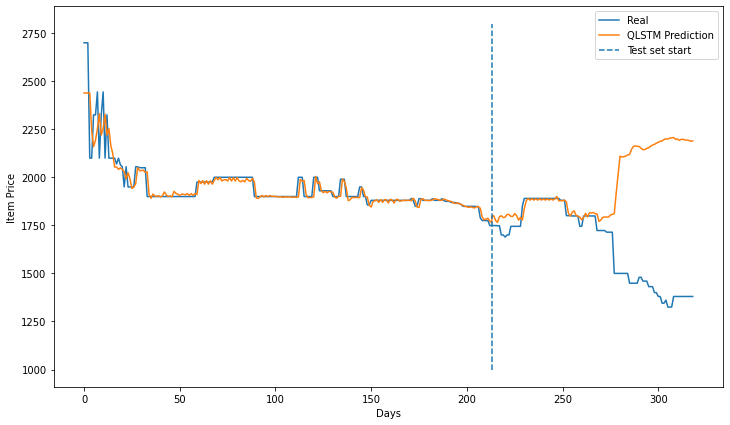

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(finalPredictions["tmrw"], label = "Real")
plt.plot(finalPredictions["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Item Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 1000, ymax = 2800, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

# Conclusion and final thoughts

   I am very happy with the results of the project, because we got decently accurate results that were down to the dollar and were mostly within one dollar of the actual price. Still, I believe this could be greatly improved if I had collected more data for the item. Unfortunately, amazon seems to be very intent on keeping data regarding price histories and such for their items out public hands, and the few sites that do have this information either obfuscate the information in HTML so that it can not be web scraped, or they paywall it for hefty prices that the average teenager just can't afford to pay. I ended up going for one of the paywalled sites but even still, the more data you request for the more it costs. I think using sentiment analysis on news articles or business articles that talk about the item could also be very useful for predicting future prices, but would take quite a bit of time to set up and provide reliable information. 
   
   This internship has been an amazing experience for me for so many reasons, as this was my first real step into the hidden world of quantum computing and machine learning. It was definitely very tough trying to learn both QC and ML at the same time, but that experience of learning so much in such a short amount of time was part of the challenge of the internship which only made the results that much more fulfilling and impressive. Thank you Q-munity for setting up this amazing program!

Lots of the code used for this project was inspired from and recycled from this github user, you should check them out if you are interested in learning about Quantum Long Short Term Memory and other applications of it outside of amazon price prediction:
https://github.com/DikshantDulal
